In [1]:
import pandas as pd
import json

In [2]:
metadata_file = r"/kaggle/input/training-data/ham10000_metadata_2024-12-23.csv"
raw_data = r"/kaggle/input/training-data/isic_images.json"

In [3]:
df = pd.read_csv(metadata_file)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9558 non-null   object 
 5   anatom_site_special     537 non-null    object 
 6   benign_malignant        9042 non-null   object 
 7   concomitant_biopsy      11720 non-null  bool   
 8   diagnosis               11720 non-null  object 
 9   diagnosis_1             11720 non-null  object 
 10  diagnosis_2             11720 non-null  object 
 11  diagnosis_3             11540 non-null  object 
 12  diagnosis_confirm_type  11720 non-null  object 
 13  image_type              11719 non-null  object 
 14  lesion_id               11720 non-null

In [5]:
with open(raw_data, 'r') as f:
    json_data = json.load(f)

In [6]:
full_img_url = {}
small_img_url = {}

for res in json_data:
    try:
        isic_id = res['isic_id']
        f_url = res['files']['full']['url']
        s_url = res['files']['thumbnail_256']['url']
    
        full_img_url[isic_id] = f_url
        small_img_url[isic_id] = s_url
    except Exception as e:
        print(e)


In [7]:
df['full_img'] = df['isic_id'].map(full_img_url)
df['small_img'] = df['isic_id'].map(small_img_url)

In [8]:
df.head(2)

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,anatom_site_special,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex,full_img,small_img
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_7252831,True,male,https://content.isic-archive.com/034c4ee0-5a13...,https://content.isic-archive.com/cf9b9fe0-52b9...
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_6125741,True,male,https://content.isic-archive.com/5b7ab18c-0456...,https://content.isic-archive.com/6f0fdd37-8e51...


In [9]:
sample_id = 'ISIC_0024750'
df_index = df[df['isic_id'] == 'ISIC_0024750'].index.to_list()[0]

obj = None
for res in json_data:
    if res['isic_id'] == sample_id:
        obj = res
        break
        
if obj['files']['full']['url'] == full_img_url[sample_id] == df.loc[df_index, 'full_img']:
    print("url matched with database")
else:
    print("full image urls do not match")

if obj['files']['thumbnail_256']['url'] == small_img_url[sample_id] == df.loc[df_index, 'small_img']:
    print("url matched with database")
else:
    print("small image urls do not match")

url matched with database
url matched with database


In [10]:
df.to_csv('ham10000_img_urls.csv', index=False)

In [11]:
df.head(5)

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,anatom_site_special,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex,full_img,small_img
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_7252831,True,male,https://content.isic-archive.com/034c4ee0-5a13...,https://content.isic-archive.com/cf9b9fe0-52b9...
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_6125741,True,male,https://content.isic-archive.com/5b7ab18c-0456...,https://content.isic-archive.com/6f0fdd37-8e51...
2,ISIC_0024308,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,55.0,NaN,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_3692653,True,female,https://content.isic-archive.com/6587e0d0-8010...,https://content.isic-archive.com/73bd2796-51b7...
3,ISIC_0024309,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,40.0,NaN,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_0959663,True,male,https://content.isic-archive.com/d12fffca-e12f...,https://content.isic-archive.com/7cf6f1c5-c217...
4,ISIC_0024310,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,60.0,anterior torso,NaN,malignant,True,melanoma,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,dermoscopic,IL_8194852,True,male,https://content.isic-archive.com/77a3b0b5-f275...,https://content.isic-archive.com/09c6f585-6750...


In [12]:
import matplotlib.pyplot as plt

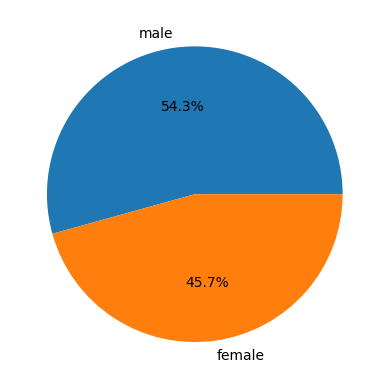

In [13]:
data = df['sex'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

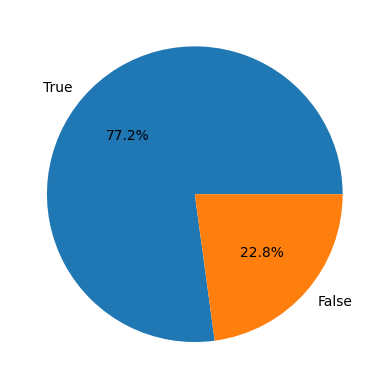

In [14]:
data = df['melanocytic'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

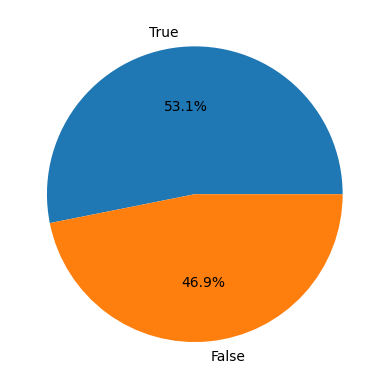

In [15]:
data = df['concomitant_biopsy'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

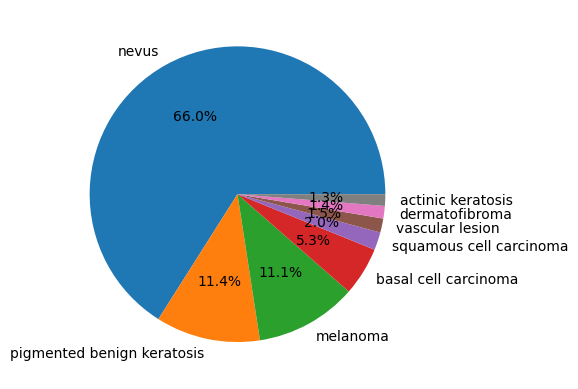

In [16]:
data = df['diagnosis'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from PIL import Image
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from timm import create_model

In [18]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.diagnosis_mapping = {label: idx for idx, label in enumerate(df['diagnosis'].unique())}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_url = self.df.iloc[idx]['full_img']
        diagnosis = self.df.iloc[idx]['diagnosis']
        
        try:
            response = requests.get(img_url)
            image = Image.open(BytesIO(response.content)).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            # Return a blank image if download fails
            image = torch.zeros((3, 224, 224))
            
        label = self.diagnosis_mapping[diagnosis]
        return image, label

In [19]:
class SkinDiseaseViT(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.train_losses.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())
        return {'val_loss': loss, 'val_acc': acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

In [20]:
class TrainingVisualizer:
    def __init__(self, model):
        self.model = model
    
    def plot_metrics(self):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.model.train_losses, label='Train Loss')
        plt.plot(self.model.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.model.val_accs, label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [21]:
def prepare_data(df, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)
    
    train_dataset = SkinLesionDataset(train_df, transform=transform)
    val_dataset = SkinLesionDataset(val_df, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    
    return train_loader, val_loader, len(train_dataset.diagnosis_mapping)

def train_model(df):
    train_loader, val_loader, num_classes = prepare_data(df)
    model = SkinDiseaseViT(num_classes=num_classes)
    
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        # callbacks=[
        #     pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max'),
        #     pl.callbacks.EarlyStopping(monitor='val_acc', patience=3, mode='max')
        # ]
    )
    
    trainer.fit(model, train_loader, val_loader)
    
    visualizer = TrainingVisualizer(model)
    visualizer.plot_metrics()
    
    return model

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

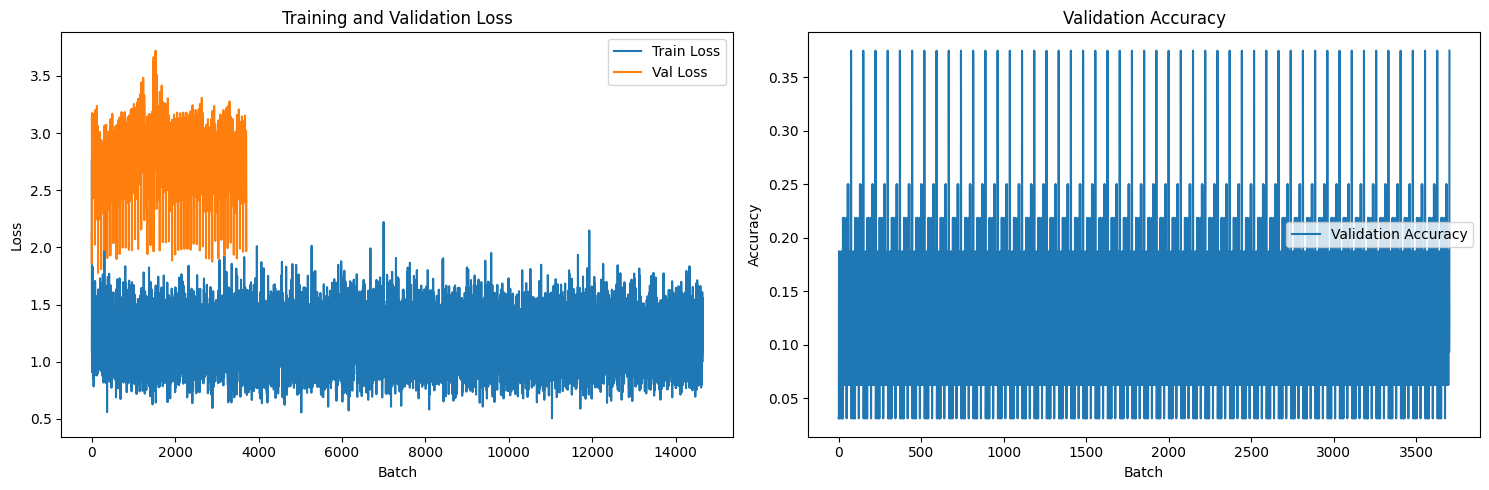

In [22]:
model = train_model(df)

In [23]:
# For making predictions
def predict_disease(model, image_url, diagnosis_mapping):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    image = transform(image).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        logits = model(image)
        probs = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
    
    reverse_mapping = {v: k for k, v in diagnosis_mapping.items()}
    return reverse_mapping[pred_idx], probs[0][pred_idx].item()

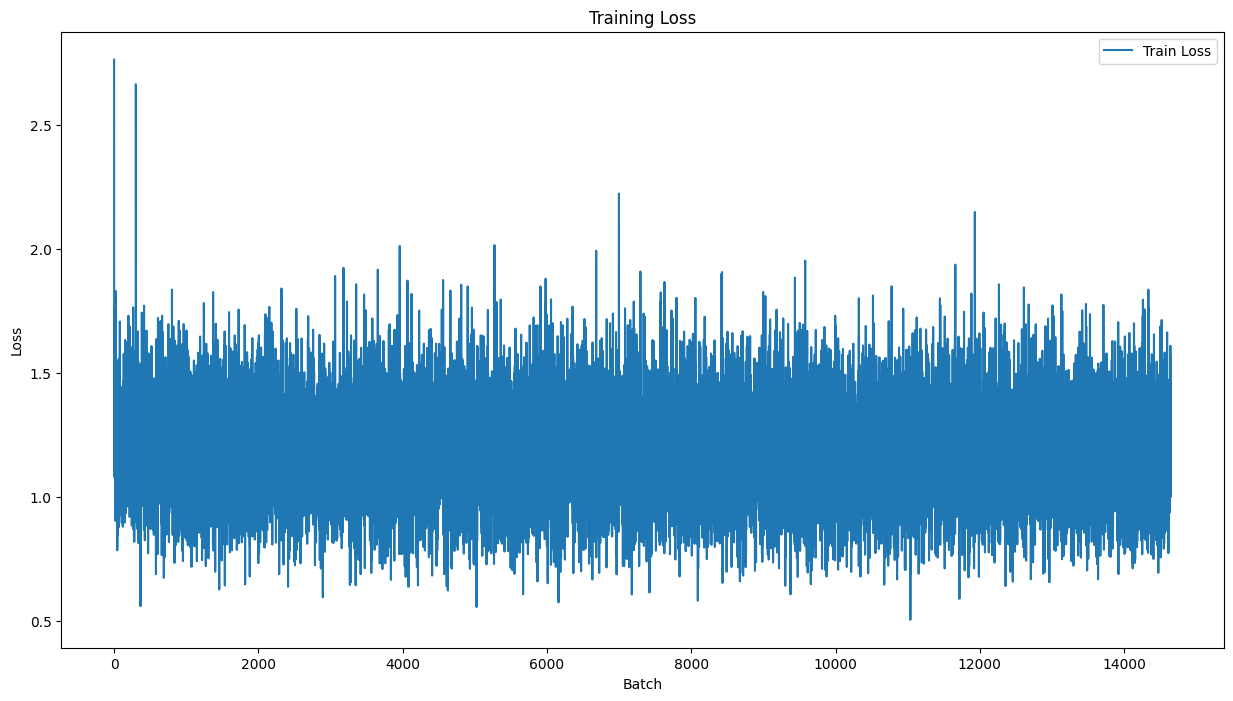

In [24]:
visualizer = TrainingVisualizer(model)

plt.figure(figsize=(15, 8))
plt.plot(visualizer.model.train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_loss_e50.png')

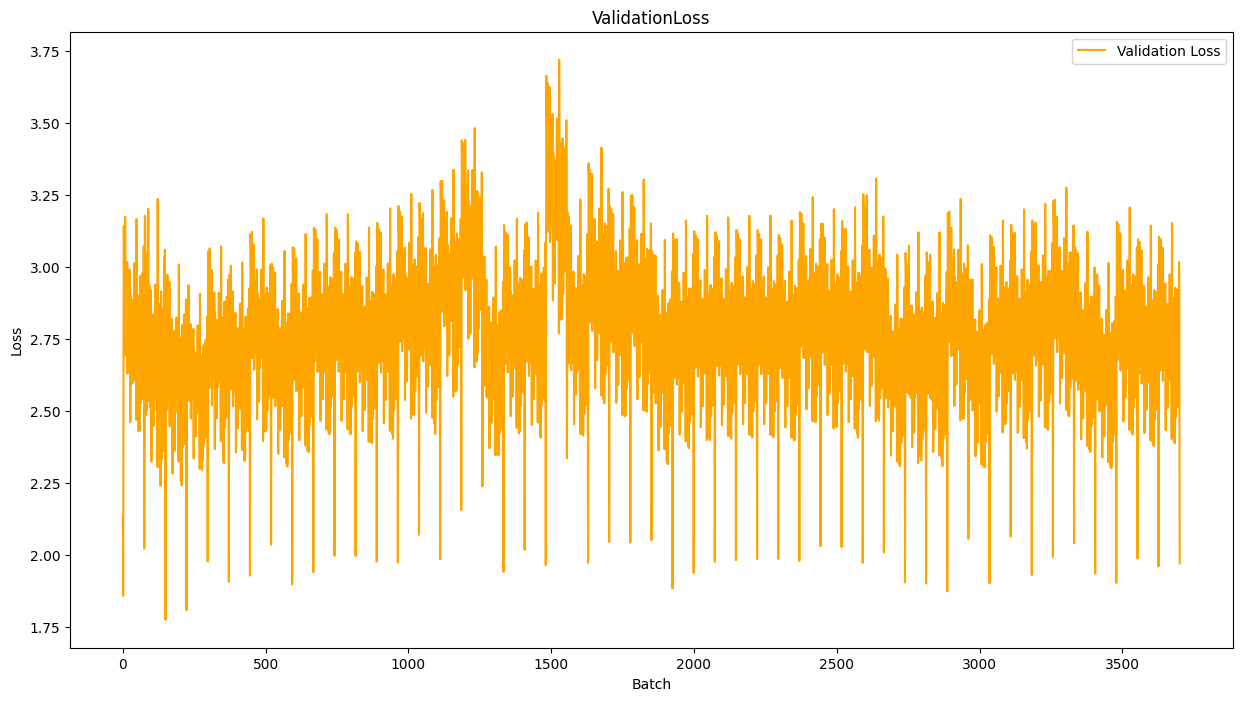

In [25]:
plt.figure(figsize=(15, 8))
plt.plot(visualizer.model.val_losses, label='Validation Loss', color='orange')
plt.title('ValidationLoss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('val_loss_e50.png')

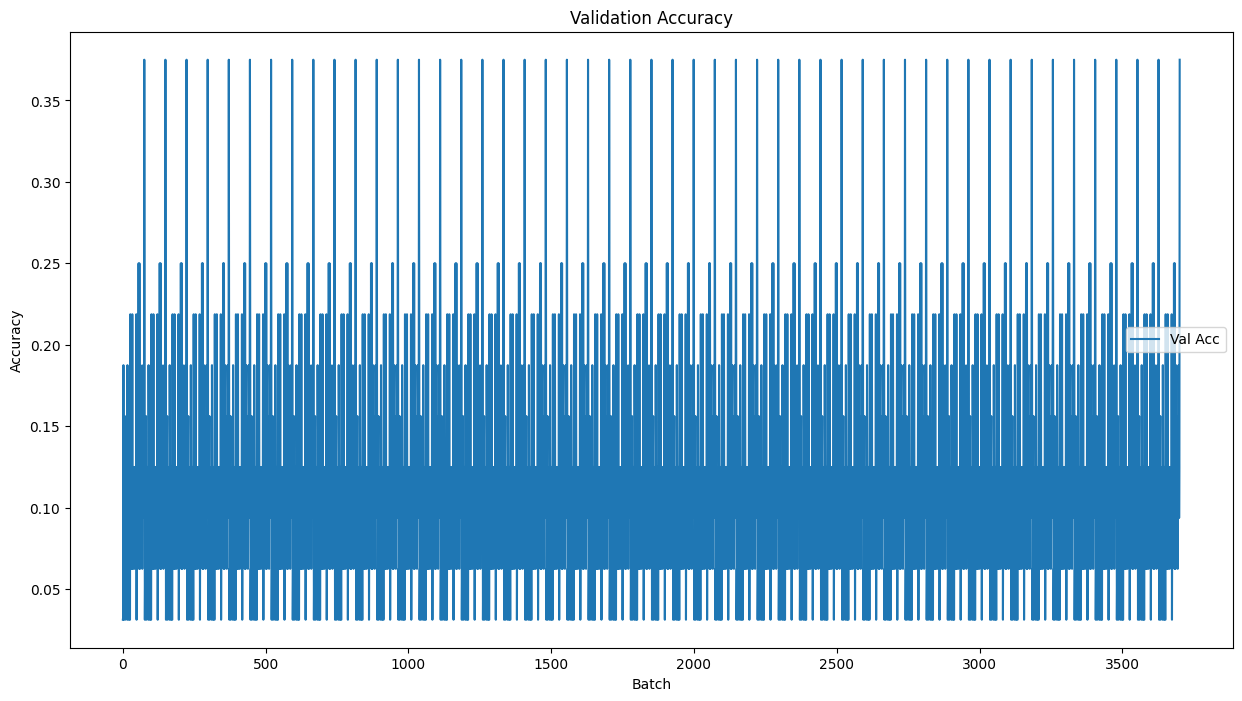

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(visualizer.model.val_accs, label='Val Acc')
plt.title('Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('val_acc_e50.png')

In [27]:
df.loc[111, 'isic_id']

'ISIC_0024417'

In [28]:
sample_id = 'ISIC_0024417'
df_index = df[df['isic_id'] == 'ISIC_0024750'].index.to_list()[0]

df.loc[df_index, ['isic_id', 'diagnosis', 'full_img']]

isic_id                                           ISIC_0024750
diagnosis                                                nevus
full_img     https://content.isic-archive.com/f7f70780-7bd5...
Name: 444, dtype: object

In [29]:
map_diag = {label: idx for idx, label in enumerate(df['diagnosis'].unique())}
img_path = df.loc[df_index, 'full_img']

In [30]:
def chatbot_diagnosis(image_path, model, diagnosis_mapping):
    diagnosis, confidence = predict_disease(model, image_path, diagnosis_mapping)
    return {
        'diagnosis': diagnosis,
        'confidence': f'{confidence:.2%}',
        'disclaimer': 'This is an AI-assisted preliminary diagnosis. Please consult a healthcare professional.'
    }

In [31]:
# print(chatbot_diagnosis(img_path, model, map_diag))

In [32]:
torch.save(model.state_dict(), "/kaggle/working/vit_model_e50.pth")

In [33]:
map_diag

{'nevus': 0,
 'melanoma': 1,
 'pigmented benign keratosis': 2,
 'dermatofibroma': 3,
 'squamous cell carcinoma': 4,
 'basal cell carcinoma': 5,
 'vascular lesion': 6,
 'actinic keratosis': 7}